In [1]:
import os
import numpy as np
import pandas as pd
import math
import shutil
import csv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, preprocess_input, decode_predictions
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input, decode_predictions
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Found GPU at: /device:GPU:0


# Make CSV

In [3]:
path = '../input/chest-xray-pneumonia/chest_xray/'
destination = './'

with open('./train.csv', 'w+', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image_path', 'label'])
    for s in ['train/','val/']:
        for root, dirs, files in os.walk(path + s):
            for f in files:
                fullpath = os.path.join(root, f)
                
                if fullpath.split('/')[-2] == 'NORMAL':
                    label = '0'
                else:
                    label = '1'
                    
                writer.writerow([fullpath, label])
                
with open('./test.csv', 'w+', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image_path', 'label'])
    for s in ['test/']:
        for root, dirs, files in os.walk(path + s):
            for f in files:
                fullpath = os.path.join(root, f)
                
                if fullpath.split('/')[-2] == 'NORMAL':
                    label = '0'
                else:
                    label = '1'
                    
                writer.writerow([fullpath, label])

print("done")

done


# Data Preprocessing

In [4]:
data_dir = "./"
labels = ['NORMAL','PNEUMONIA']
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

In [5]:
pd.set_option('max_colwidth', 800)
df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

df.head(3)

,image_path,label
0,../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg,1
1,../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1230_virus_2081.jpeg,1
2,../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1513_virus_2632.jpeg,1


In [6]:
df['label'] = df['label'].astype('str')
test_df['label'] = test_df['label'].astype('str')

In [7]:
neg, pos = np.bincount(df['label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 5232
    Positive: 3883 (74.22% of total)



In [8]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=13, stratify=df['label'])
len(train_df), len(valid_df)

(4185, 1047)

In [9]:
neg, pos = np.bincount(train_df['label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 4185
    Positive: 3106 (74.22% of total)



# Calculate Class Weight (Optional)

In [10]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


# Oversampling (Optional)

In [11]:
bool_train_labels = train_df['label']!='0'

pos_features = train_df['image_path'][bool_train_labels]
neg_features = train_df['image_path'][~bool_train_labels]

pos_labels = train_df['label'][bool_train_labels]
neg_labels = train_df['label'][~bool_train_labels]

len(pos_features), len(neg_features)

(3106, 1079)

In [12]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[pos_features.index[choices]]
res_pos_labels = pos_labels[pos_labels.index[choices]]

res_pos_features.head(3)

1324    ../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1102_bacteria_3043.jpeg
333     ../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1680_bacteria_4455.jpeg
3424     ../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person995_bacteria_2923.jpeg
Name: image_path, dtype: object

In [13]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_data = {'image_path': resampled_features,
        'label': resampled_labels
        }

resampled_df = pd.DataFrame(resampled_data, columns = ['image_path', 'label'])
resampled_df.head(3)

,image_path,label
0,../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1300_bacteria_3264.jpeg,1
1,../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1283_bacteria_3246.jpeg,1
2,../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person765_bacteria_2669.jpeg,1


# Image Data Generator

In [14]:
train_datagen = ImageDataGenerator(
#     rescale=1./255,
    preprocessing_function=preprocess_input,
    rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    brightness_range=[0.6, 1.3],
    shear_range=0.3,
    zoom_range=[0.8, 1.0],
#     horizontal_flip=True,
#     vertical_flip=True,
    fill_mode='constant'
)

test_datagen = ImageDataGenerator(
#     rescale=1./255,
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_dataframe(
                                        dataframe=train_df,
                                        x_col='image_path',
                                        y_col='label',
                                        class_mode='binary',
                                        target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE)

validation_generator = test_datagen.flow_from_dataframe(
                                        dataframe=valid_df,
                                        x_col='image_path',
                                        y_col='label',
                                        class_mode='binary',
                                        shuffle=False,
                                        target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_dataframe(
                                        dataframe=test_df,
                                        x_col='image_path',
                                        y_col='label',
                                        class_mode='binary',
                                        shuffle=False,
                                        target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


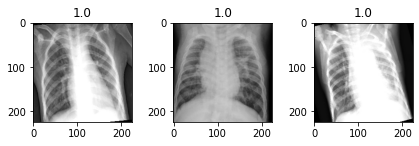

In [15]:
fig, axes = plt.subplots(1, 3)
fig.tight_layout()

for i in range(3):
    img, label = train_generator.next()
    axes[i].set_title(label[0])  
    axes[i].imshow(img[0].astype(int))

# Build and Train Model

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
dr = 0.4

base_model = EfficientNetB0(
    weights='imagenet',
    input_shape=IMG_SHAPE,
    include_top=False,
    drop_connect_rate=dr
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(dr),
    
#     Dense(64),
#     BatchNormalization(),
#     Activation("relu"),
#     Dropout(dr),
    
    Dense(1),
    BatchNormalization(),
    Activation("sigmoid"),
])

model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1)                 4         
_________________________________________________________

In [17]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.AUC(name="AUC"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=BinaryCrossentropy(),
              metrics=metrics)

In [18]:
callbacks = [
#              ModelCheckpoint("model_at_epoch_{epoch}.h5"),
#              ReduceLROnPlateau(monitor='val_loss',
#                             patience=2,
#                             verbose=1,
#                             factor=0.07,
#                             min_lr=1e-9),
             EarlyStopping(monitor='val_loss', patience=3, verbose=1)
]

history = model.fit(train_generator, 
                    epochs=10,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=validation_generator,
                    class_weight=class_weights
)

Epoch 1/10
262/262 [==============================] - 151s 532ms/step - loss: 0.5343 - binary_acc: 0.6994 - AUC: 0.8192 - precision: 0.9181 - recall: 0.6562 - val_loss: 0.4924 - val_binary_acc: 0.8424 - val_AUC: 0.9818 - val_precision: 0.9920 - val_recall: 0.7941
Epoch 2/10
262/262 [==============================] - 106s 403ms/step - loss: 0.3939 - binary_acc: 0.8275 - AUC: 0.9506 - precision: 0.9826 - recall: 0.7813 - val_loss: 0.3990 - val_binary_acc: 0.8596 - val_AUC: 0.9849 - val_precision: 0.9984 - val_recall: 0.8121
Epoch 3/10
262/262 [==============================] - 105s 399ms/step - loss: 0.3404 - binary_acc: 0.8637 - AUC: 0.9677 - precision: 0.9849 - recall: 0.8288 - val_loss: 0.3989 - val_binary_acc: 0.8348 - val_AUC: 0.9858 - val_precision: 0.9983 - val_recall: 0.7786
Epoch 4/10
262/262 [==============================] - 106s 403ms/step - loss: 0.3122 - binary_acc: 0.8706 - AUC: 0.9696 - precision: 0.9838 - recall: 0.8404 - val_loss: 0.3167 - val_binary_acc: 0.8863 - val_A

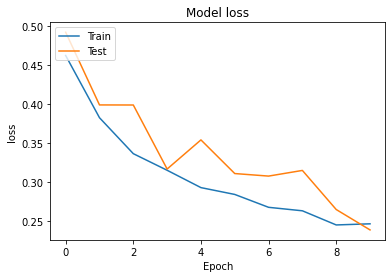

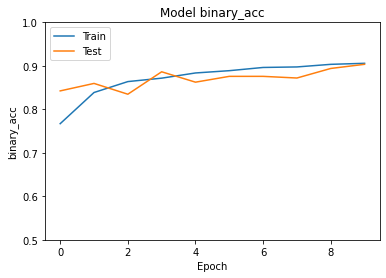

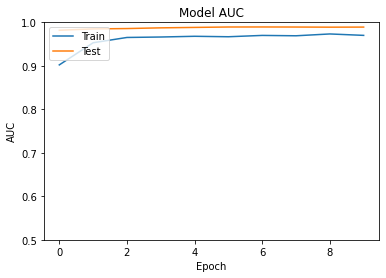

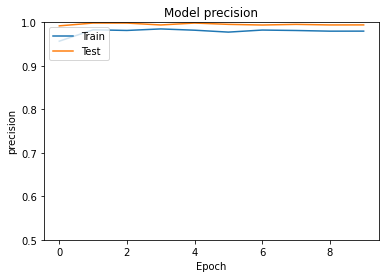

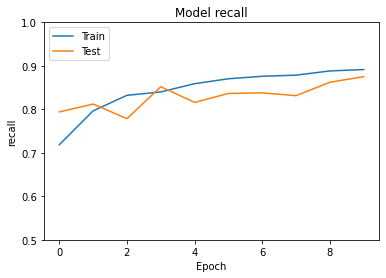

In [19]:
def plot_metrics(history, name, bot=0.0, top=0.0):
    plt.plot(history.history[name])
    plt.plot(history.history['val_'+name])
    plt.title('Model '+name)
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if top != 0.0:
        plt.ylim([bot, top])
    plt.show()

plot_metrics(history, 'loss')
for i in range(len(metrics)):
    plot_metrics(history, metrics[i].name, 0.5, 1.0)

## Fine-tuning Model

In [20]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  237


In [21]:
for layer in base_model.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

In [22]:
metrics = [
#     tf.keras.metrics.BinaryAccuracy(name="bin_acc"),
    tf.keras.metrics.AUC(name="AUC"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(),
              metrics=metrics)

In [23]:
callbacks = [
#              ModelCheckpoint("model_at_epoch_{epoch}.h5"),
#              ReduceLROnPlateau(monitor='val_loss',
#                             patience=2,
#                             verbose=1,
#                             factor=0.07,
#                             min_lr=1e-9),
             EarlyStopping(monitor='val_loss', patience=3, verbose=1)
            ]

history = model.fit(train_generator, 
                    epochs=15,
#                     steps_per_epoch=resampled_steps_per_epoch,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=validation_generator,
#                     class_weight=class_weights
                   )

Epoch 1/15
262/262 [==============================] - 119s 428ms/step - loss: 0.2660 - AUC: 0.9706 - precision: 0.9779 - recall: 0.8856 - val_loss: 0.2409 - val_AUC: 0.9894 - val_precision: 0.9942 - val_recall: 0.8764
Epoch 2/15
262/262 [==============================] - 111s 422ms/step - loss: 0.2540 - AUC: 0.9751 - precision: 0.9841 - recall: 0.9011 - val_loss: 0.2451 - val_AUC: 0.9896 - val_precision: 0.9941 - val_recall: 0.8739
Epoch 3/15
262/262 [==============================] - 110s 420ms/step - loss: 0.2560 - AUC: 0.9728 - precision: 0.9811 - recall: 0.8904 - val_loss: 0.2376 - val_AUC: 0.9898 - val_precision: 0.9942 - val_recall: 0.8803
Epoch 4/15
262/262 [==============================] - 108s 414ms/step - loss: 0.2529 - AUC: 0.9738 - precision: 0.9781 - recall: 0.9015 - val_loss: 0.2400 - val_AUC: 0.9900 - val_precision: 0.9942 - val_recall: 0.8816
Epoch 5/15
262/262 [==============================] - 109s 416ms/step - loss: 0.2580 - AUC: 0.9709 - precision: 0.9758 - recall:

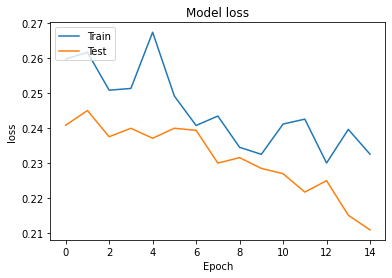

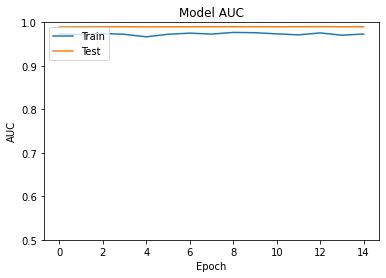

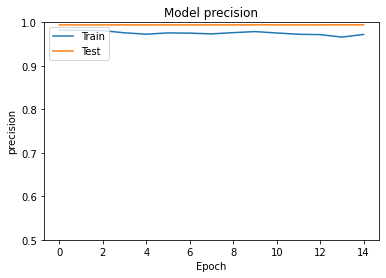

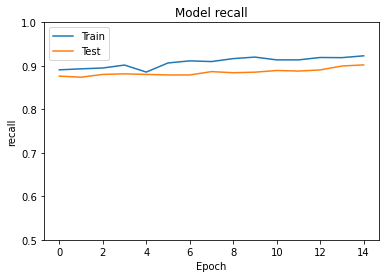

In [24]:
plot_metrics(history, 'loss')
for i in range(len(metrics)):
    plot_metrics(history, metrics[i].name, 0.5, 1.0)

# Evaluate Model

In [25]:
model.evaluate(test_generator, batch_size=BATCH_SIZE)

39/39 [==============================] - 9s 242ms/step - loss: 0.2612 - AUC: 0.9659 - precision: 0.9158 - recall: 0.9487


[0.2611630856990814,
 0.9658830761909485,
 0.9158415794372559,
 0.9487179517745972]

In [26]:
Y_pred = model.predict(test_generator, batch_size=BATCH_SIZE)

y_pred = np.rint(Y_pred)

## Plot Confusion Matrix

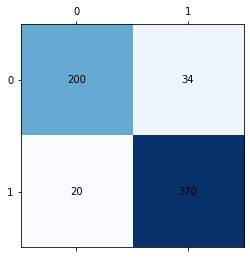

In [27]:
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

plt.matshow(conf_matrix, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(conf_matrix):
    plt.text(j, i, z, ha='center', va='center')

In [28]:
print('Classification Report')
target_names = ['0','1']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       234
           1       0.92      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



## Plot Top Losses

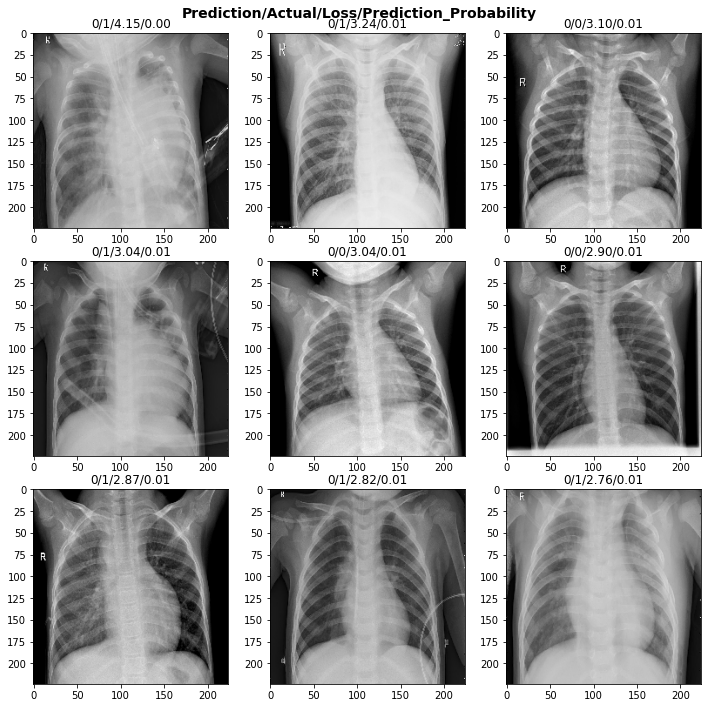

In [29]:
def plot_top_losses(actual, pred, k=9, figsize=(10,10)):
    loss = BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    loss_values = loss(actual, pred).numpy()
    top_k = loss_values.argsort()[-k:][::-1]
    cols = math.ceil(math.sqrt(k))
    rows = math.ceil(k/cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14)
    fig.tight_layout()
    for i, index in enumerate(top_k):
        image = validation_generator[int(index/16)][0][index%16]
        actual = validation_generator.classes[index]
        loss_value = loss_values[index]
        predicted = np.argmax(pred[index])
        prob = pred[index][predicted]
        title = f'{predicted}/{actual}/{loss_value:.2f}/{prob:.2f}'
        ax = axes.flat[i]
        ax.imshow(image.astype(int))
        ax.set_title(title)
        
plot_top_losses(test_generator.classes, Y_pred, 9)